In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import random
import time
from statistics import mean

In [2]:
# Set all relevant seeds

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Load and Preprocess Data for CNN

sMRI_path = '/home/giov_armando/Desktop/OpenBHB/val_vbm/'
labels_path = '/home/giov_armando/Desktop/OpenBHB/val_labels/participants.tsv'

# Load labels
df_labels = pd.read_csv(labels_path, sep='\t')
df_labels

file_list = os.listdir(sMRI_path)
X_paths = []
y = []

# Check data and get rid of spoiled files
for filename in file_list:
    path = os.path.join(sMRI_path, filename)
    
    # Try loading .npy files 
    try:
        x = np.load(path)
        x = np.squeeze(x)
    except Exception as e:
        print(f"[Bad file] {filename} → {e}")
        continue  # salta questo file
    
    # extract participant ID
    try:
        part_ID = int(filename.split('_')[0].split('-')[1])
    except:
        continue
    
    # Match with labels table
    row = df_labels[df_labels['participant_id'] == part_ID]
    if not row.empty:
        X_paths.append(path)
        y.append(row.iloc[0]['age'])


X_paths_tensor = tf.constant(X_paths)
y_tensor = tf.constant(y, dtype=tf.float32)
tf_data = tf.data.Dataset.from_tensor_slices((X_paths_tensor, y_tensor))


# Preprocess Data
def preprocess(path, label):
    # Load and process file
    def load_file(path_string):
        x = np.load(path_string.decode('utf-8'))
        x = np.squeeze(x)
        x = x / np.max(x)
        x = np.expand_dims(x, axis=-1)
        x = x.astype(np.float32)
        return x

    # Convert to tf and set shape
    x = tf.numpy_function(load_file, [path], tf.float32)
    x.set_shape([121, 145, 121, 1])
    return x, label


# Map, shuffle and batch
dataset = tf_data.map(preprocess, num_parallel_calls = tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size = len(X_paths))
dataset = dataset.batch(batch_size = 1)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

[Bad file] sub-714350956036_preproc-cat12vbm_desc-gm_T1w.npy → cannot reshape array of size 119280 into shape (121,145,121,1,1)
[Bad file] sub-714412157456_preproc-cat12vbm_desc-gm_T1w.npy → No data left in file
[Bad file] sub-715300585465_preproc-cat12vbm_desc-gm_T1w.npy → No data left in file


2025-04-09 18:15:07.179279: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


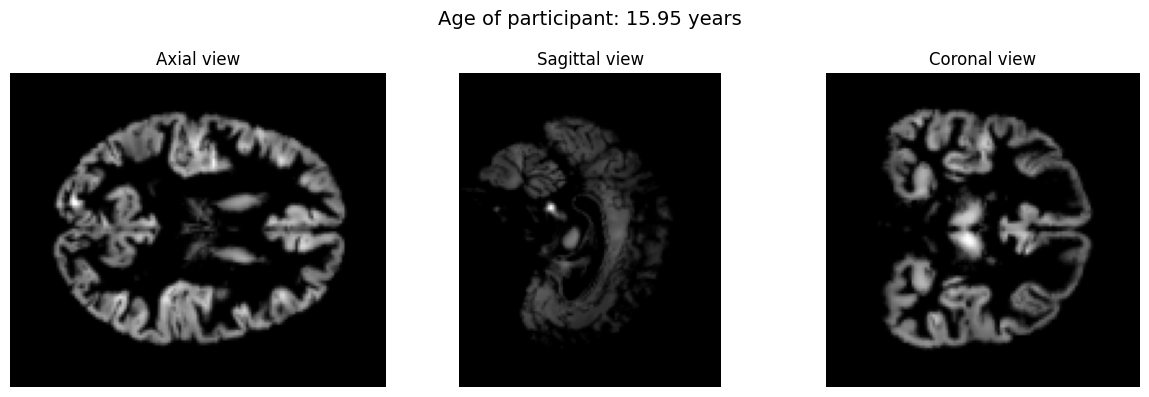

2025-04-09 18:15:12.456883: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Plot MRIs

for x_batch, y_batch in dataset.take(1):
    volume = x_batch[0]      
    age = y_batch[0].numpy()

    # Calculate central indixes
    axial_idx = volume.shape[2] // 2      #along z-axis
    sagittal_idx = volume.shape[0] // 2   #along x-axis
    coronal_idx = volume.shape[1] // 2    #along y-axis

    # Extract slice images along the 3 dimensions
    axial_slice = volume[:, :, axial_idx, 0]
    sagittal_slice = volume[sagittal_idx, :, :, 0]
    coronal_slice = volume[:, coronal_idx, :, 0]

    # Plot in subplot 
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(axial_slice, cmap='gray')
    axs[0].set_title("Axial view")

    axs[1].imshow(sagittal_slice, cmap='gray')
    axs[1].set_title("Sagittal view")

    axs[2].imshow(coronal_slice, cmap='gray')
    axs[2].set_title("Coronal view")

    fig.suptitle(f"Age of participant: {age:.2f} years", fontsize=14)

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [6]:
# Load and Preprocess Data for ML (non-deep algorithms)

labels_path = '/home/giov_armando/Desktop/OpenBHB/val_labels/participants.tsv'

# Load data
df_labels = pd.read_csv(labels_path, sep='\t')

# Target
age = df_labels.age 

# Features
tiv = df_labels.tiv                        #total intracranial volume (cm^3)
gmv = df_labels.gmv                        #gray matter volume (cm^3)
wmv = df_labels.wmv                        #white matter volume (cm^3)
csfv = df_labels.csfv                      #cerebrospinal fluid volume (cm^3)
mft = df_labels.magnetic_field_strength    #magnetic field strength (Tesla)



# Target
y = df_labels.age

# Numerical Features ( before and after scaling)
X0 = df_labels[['tiv', 'gmv', 'wmv', 'csfv', 'magnetic_field_strength']]

scaler = StandardScaler()
X0_scaled = scaler.fit_transform(X0)
X0_data = pd.DataFrame(X0_scaled, columns = X0.columns)

# Categorical Features (study, sex, site)
df_encoded = pd.get_dummies(df_labels, columns = ['study', 'sex', 'site'], drop_first = True)
df_cat = [col for col in df_encoded.columns if col.startswith('study_') or
                                            col.startswith('sex_') or
                                             col.startswith('site_')]

X_cat = df_encoded[df_cat]

# Combine all features
X = pd.concat([X0_data, X_cat], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

MAE = 4.46 years
MSE = 38.99 years
R2 = 0.79 years 
 

Most relevant features: 
 
   Feature  Coefficients
0     tiv    435.528123
1     gmv   -256.148567
2     wmv   -187.316246
3    csfv   -185.579231


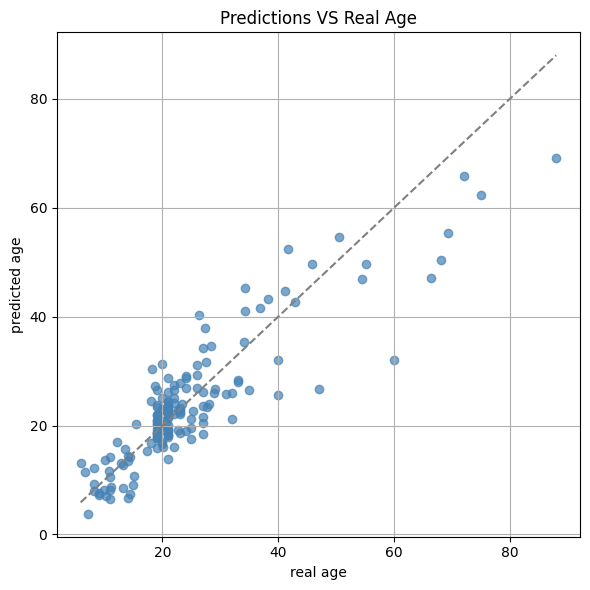

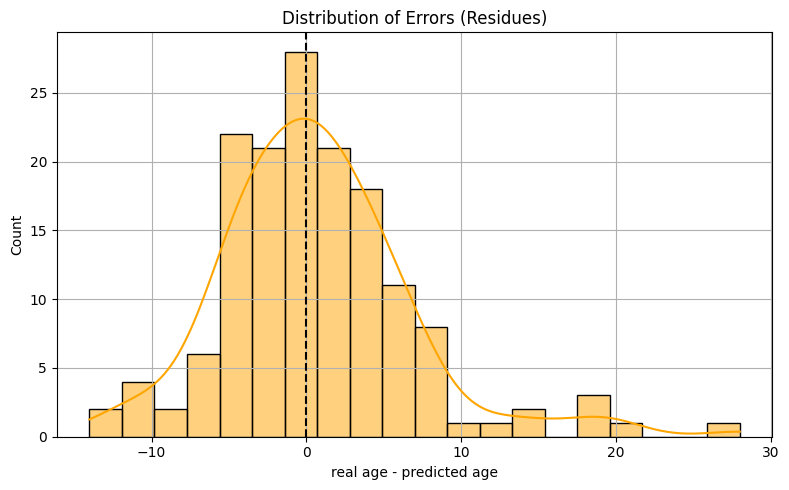

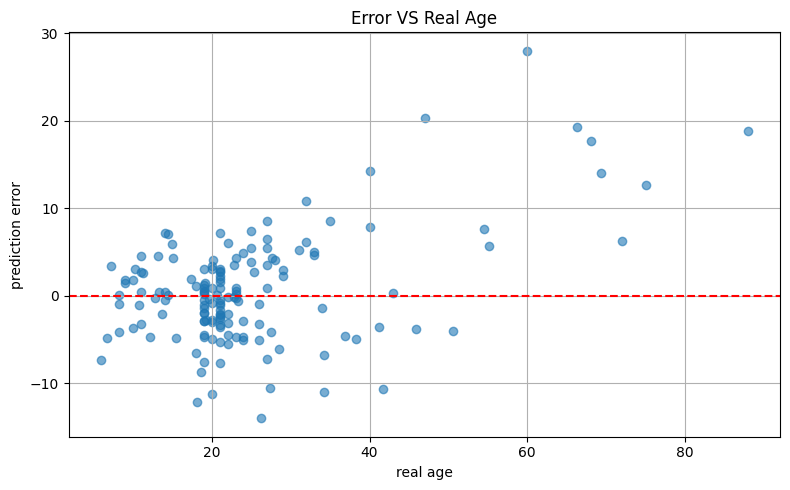

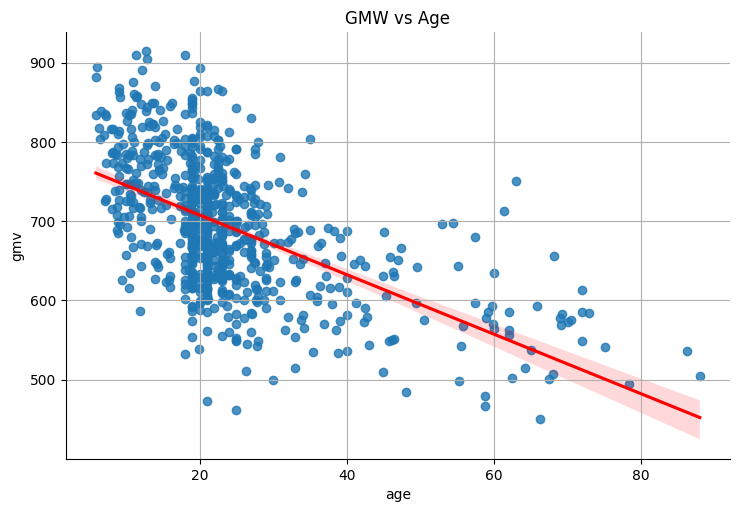

In [37]:
# Linear Regression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

# Calculate and print accuracy metrics
MAE_LR = mean_absolute_error(y_test, y_pred)
MSE_LR = mean_squared_error(y_test, y_pred)
R2_LR = r2_score(y_test, y_pred)

print(f"MAE = {MAE_LR:.2f} years")
print(f"MSE = {MSE_LR:.2f} years")
print(f"R2 = {R2_LR:.2f} years \n \n")


# Extract coefficients of various features
features = X.columns
coefs = reg.coef_

coef_pd = pd.DataFrame({
    'Feature': features,
    'Coefficients': coefs
}).sort_values(by='Coefficients', key=abs, ascending=False)

top_features = coef_pd.reindex(coef_pd['Coefficients'].abs().sort_values(ascending=False).index).head(4)

print("Most relevant features: \n \n", top_features)


# 
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.xlabel("real age")
plt.ylabel("predicted age")
plt.title("Predictions VS Real Age")
plt.grid(True)
plt.tight_layout()
plt.show()

errors = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=20, kde=True, color='orange')
plt.title("Distribution of Errors (Residues)")
plt.xlabel("real age - predicted age")
plt.axvline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
plt.scatter(y_test, errors, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("real age")
plt.ylabel("prediction error")
plt.title("Error VS Real Age")
plt.grid(True)
plt.tight_layout()
plt.show()

sns.lmplot(data=df_labels, x='age', y='gmv', height=5, aspect=1.5, line_kws={'color': 'red'})
plt.title('GMW vs Age')
plt.grid(True)
plt.show()


In [5]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [ ]:
#Benchmark 3D CNN

# CNN architecture
model = models.Sequential([
    layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', input_shape=(121, 145, 121, 1)),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),
    layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D(pool_size=(2, 2, 2)),
    layers.GlobalAveragePooling3D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='linear')
])

# Model Summary
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

start_time=time.time()

history = model.fit(
    dataset,
    epochs = 10,
    verbose = 2
)

end_time = time.time()

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['mae'], label='Training MAE')
plt.show()

model.save("benchmark_model.h5")

# Evaluate the model on the training data
train_loss, train_mae = model.evaluate(dataset, verbose=1)
print(f"Train Loss: {train_loss}, Train MAE: {train_mae}")

print(f"Training time: {(end_time - start_time)/60:.2f} minutes")



/home/giov_armando/jupyter_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)               │ (None, 121, 145, 121,  │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 60, 72, 60, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 60, 72, 60, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 30, 36, 30, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,657 (72.88 KB)

 Trainable params: 18,657 (72.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
